# Parallel Computing
- multiprocessing
- dask

In [1]:
import numpy as np
import matplotlib.pyplot as plt

/home/jcartus/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Measuring the executing time
A way to measure the execution time is [timeit](https://docs.python.org/3/library/timeit.html). It executes the code in question multiple times and reports the average elapsed time. The longer the code runs, the fewer it will be rerun.


There is a practical [adaption for ipython](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit), which is the backend for the jupyter notebook you are using at the momment. 

Use it by writing
```%%timeit```
At the top of of a cell.

In [2]:
%%timeit

# create 1000 random values and sum them up
np.sum(np.random.rand(1000))

/home/jcartus/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


10.1 µs ± 394 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### Custom timer
Based on [this answer from stackoverflow](https://stackoverflow.com/a/5849861) we will build a timer as a [contextmanger](https://docs.python.org/3/library/contextlib.html).

In [3]:
import time

class Timer(object):
    
    def __enter__(self):
        self.t_start = time.time()
        return self

    def __exit__(self, etype, value, traceback):
        self.t_end = time.time()
    
    @property
    def elapsed(self):
        return self.t_end - self.t_start

In [4]:
with Timer() as t:
    np.sum(np.random.rand(1000))
    
print(f"Time elapsed {t.elapsed * 1e6:1.3f} mu seconds")

Time elapsed 48.876 mu seconds


# Numpy
Numpy has actually a lot of its math operations very nice parallelized. They are very well optimized and much faster then using loops and probably also anythoing parallel you build yourself. 

In [5]:
a = np.random.rand(1000)
b = np.random.rand(1000)

In [6]:
%%timeit

# vectorized/parallel
a*b

724 ns ± 39.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [8]:
%%timeit

# using a loop 

# put the result into this buffer
c = np.ones_like(a)

for i in range(len(a)):
    c[i] = a[i] * b[i]

341 µs ± 20.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


/home/jcartus/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Parallelcomputing libraries
There are a lot of different libraries for parallel computation in python all of which have their unique strengths and weaknesses. A good overview over available libraries can be found here: https://wiki.python.org/moin/ParallelProcessing

# Multiprocessing
[multiprocessing](https://docs.python.org/3.8/library/multiprocessing.html) is one of the tools from the list mentioned above. It quite powerful, but also has an easy-to-use high-level interface.

Below I will demonstrate how to process a list in parallel by applying an opertion to every list element.

In [9]:
import multiprocessing as mp

In [47]:
def f(x):
    """Funciton we will apply to the array elements"""
    
    # this is a complicated funciton. 
    # it takes a long time ti do this calculation.
    # to emulate this we will sleep a little
    time.sleep(0.1)
    
    # so that at least some math is done we return the square
    return x*x

In [48]:
# a random array to test on
array = list(np.random.rand(10))

In [49]:
%%timeit 
list(map(f, array))

1 s ± 59.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
%%timeit 
with mp.Pool(6) as p:
    list(p.map(f, array))

363 ms ± 10.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [58]:
def time_parallel_execution(n_elements):
    """Map a function to a random array of n_elements and 
    time how long the execution takes"""

    # create a random array with n_elemements elements
    array = [np.random.rand() for i in range(n_elements)]
    
    
    #--- do the calculation serial ---
    with Timer() as timer_serial:
        for a in array:
            f(a)
    #---

    
    #--- do the calculation in parallel ---
    # spawn a pool of workers
    with mp.Pool() as p:
        
        with Timer() as timer_parallel:
            # map the funciton f onto all elements of the array
            # since we only want to measure speed we will not
            # use the result for anything.
            r = p.map(f, array)
    #---
    #print(r)
    return timer_serial.elapsed, timer_parallel.elapsed

time_parallel_execution(100)

(10.01737356185913, 1.605027437210083)

In [67]:
n = [1,  5, 10, 15, 20, 30, 40, 50, 75, 100, 200, 500]

t_serial, t_parallel = [], []
for ni in n:
    print(f"Doing: {ni}")
    t_s, t_p = time_parallel_execution(ni)
    t_serial.append(t_s)
    t_parallel.append(t_p)

Doing: 1
Doing: 5
Doing: 10
Doing: 15
Doing: 20
Doing: 30
Doing: 40
Doing: 50
Doing: 75
Doing: 100
Doing: 200
Doing: 500


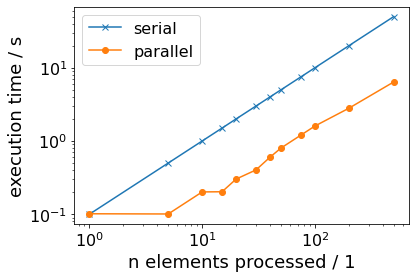

In [71]:
plt.loglog(n, t_serial, "x-", label="serial")
plt.loglog(n, t_parallel, "o-", label="parallel")

plt.xlabel("n elements processed / 1", fontsize=18)
plt.ylabel("execution time / s", fontsize=18)

plt.legend(fontsize=16);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);

## Beware: parallelism takes time.
If the function you are mapping onto the iterable is very fast, it may not be feasible to do this is parallel!

In [55]:
def simple_f(x):
    # easy and very fast to evaluate
    return x**2

In [56]:
%%timeit 
list(map(simple_f, array))

2.79 µs ± 24.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [57]:
%%timeit 
with mp.Pool() as p:
    list(p.map(simple_f, array))

182 ms ± 12.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Dask DataFrames
I just wanted to leave this link here: if you ever need a larger scale version of pandas.DataFrames please checkiut [dask.DataFrames](https://docs.dask.org/en/latest/dataframe.html). Their interface is almost identical to pandas but calculations and data handling can be done distributed. 